In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0
torch:  2.0 ; cuda:  cu117
detectron2: 0.6


In [2]:
import os
import sys
import logging
import argparse
os.environ["DATASET"] = "../datasets"

pth = '/'.join(sys.path[0].split('/')[:-1])
sys.path.insert(0, pth)

from pprint import pprint
import numpy as np
np.random.seed(1)

home_dir = os.path.abspath(os.getcwd()+"/../")
sys.path.append(home_dir)
print(home_dir)

import warnings
warnings.filterwarnings(action='ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from xdecoder.BaseModel import BaseModel
from xdecoder import build_model
from utils.distributed import init_distributed
from utils.arguments import load_opt_from_config_files, load_config_dict_to_opt

/home/djjin/Mygit/X-Decoder


Invalid MIT-MAGIC-COOKIE-1 key

In [3]:
import yaml
import json
import argparse
import logging
import os

def load_vcoco_parser():
    parser = argparse.ArgumentParser(description='Pretrain or fine-tune models for NLP tasks.')
    parser.add_argument('--command', default="evaluate", help='Command: train/evaluate/train-and-evaluate')
    parser.add_argument('--conf_files', nargs='+', help='Path(s) to the config file(s).')
    parser.add_argument('--user_dir', help='Path to the user defined module for tasks (models, criteria), optimizers, and lr schedulers.')
    parser.add_argument('--config_overrides', nargs='*', help='Override parameters on config with a json style string, e.g. {"<PARAM_NAME_1>": <PARAM_VALUE_1>, "<PARAM_GROUP_2>.<PARAM_SUBGROUP_2>.<PARAM_2>": <PARAM_VALUE_2>}. A key with "." updates the object in the corresponding nested dict. Remember to escape " in command line.')
    parser.add_argument('--overrides', help='arguments that used to override the config file in cmdline', nargs=argparse.REMAINDER)
    cmdline_args = parser.parse_args('')
    return cmdline_args

def load_vcoco_opt_command(cmdline_args):
    opt = load_opt_from_config_files(cmdline_args.conf_files)
    opt["base_path"] = "../"

    keys = [cmdline_args.overrides[idx*2] for idx in range(len(cmdline_args.overrides)//2)]
    vals = [cmdline_args.overrides[idx*2+1] for idx in range(len(cmdline_args.overrides)//2)]
    vals = [val.replace('false', '').replace('False','') if len(val.replace(' ', '')) == 5 else val for val in vals]
    types = []
    for key in keys:
        key = key.split('.')
        ele = opt.copy()
        while len(key) > 0:
            ele = ele[key.pop(0)]
        types.append(type(ele))

    config_dict = {x:z(y) for x,y,z in zip(keys, vals, types)}

    load_config_dict_to_opt(opt, config_dict)
    for key, val in cmdline_args.__dict__.items():
        if val is not None:
            opt[key] = val

    return opt

cmdline_args = load_vcoco_parser()
cmdline_args.conf_files = [os.path.join(home_dir, "configs/xdecoder/segvlp_focalt_lang.yaml")]
# cmdline_args.overrides = ['WEIGHT', 'true', 'RESUME_FROM', '../checkpoints/xdecoder_focalt_best_openseg.pt'] 
cmdline_args.overrides = ['DONT_LOAD_MODEL', 'false', 'PYLEARN_MODEL', '../data/output/test/00062100/default/raw_model_states.pt'] 


opt = load_vcoco_opt_command(cmdline_args)
opt = init_distributed(opt)

In [4]:
from datasets.build import build_train_dataloader
train_data_loader = build_train_dataloader(opt)
dataset_names = opt['DATASETS']['TRAIN']
print(len(train_data_loader))

INFO:datasets.dataset_mappers.coco_panoptic_new_baseline_dataset_mapper:[COCOPanopticNewBaselineDatasetMapper] Full TransformGens used in training: [RandomFlip(), ResizeScale(min_scale=0.1, max_scale=2.0, target_height=1024, target_width=1024), FixedSizeCrop(crop_size=(1024, 1024))]
INFO:datasets.build:Using training sampler TrainingSampler
INFO:detectron2.data.common:Serializing 112580 elements to byte tensors and concatenating them all ...
INFO:detectron2.data.common:Serialized dataset takes 204.50 MiB


56290


[[ 641.  323.  658.  340.]
 [ 482.  333.  518.  362.]
 [ 213.  295.  245.  332.]
 [ 800.  400.  837.  416.]
 [ 751.  347.  800.  406.]
 [ 585.  353.  596.  380.]
 [ 414.  375.  430.  408.]
 [ 279.  269.  319.  327.]
 [ 830.  401.  860.  441.]
 [ 658.  323.  688.  353.]
 [ 452.  352.  477.  375.]
 [ 739.  386.  777.  425.]
 [ 596.  358.  638.  393.]
 [ 150.  196. 1024.  459.]
 [  62.  189.  918.  597.]
 [ 163.  498.  419.  537.]
 [ 653.  441.  716.  507.]
 [   0.    0. 1024.  272.]
 [   0.  148. 1024.  493.]]


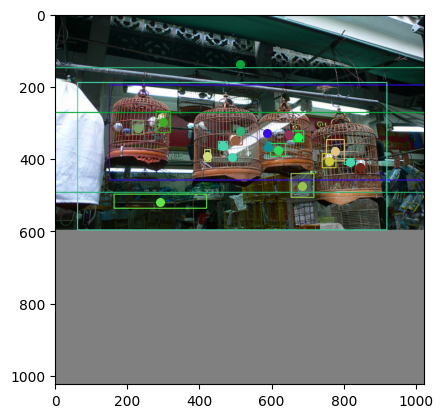

[[ 386.  369.  518.  613.]
 [   0.  159.  315.  825.]
 [   0.    0.    0.    0.]
 [ 851.  705.  969.  841.]
 [ 404.  631.  777.  893.]
 [   0.    0.    0.    0.]
 [   0.  505. 1018. 1024.]
 [  93. 1016.  256. 1024.]
 [ 617.  594. 1024.  979.]
 [ 731.    0. 1024.  529.]]


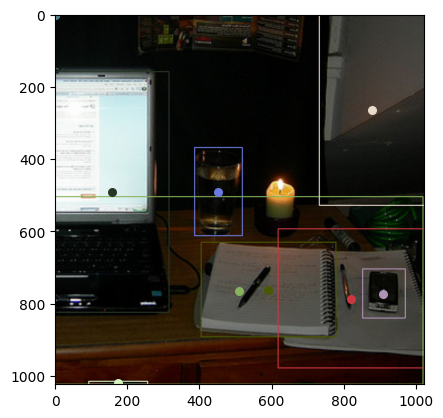

[[  3.  36.  39. 174.]
 [130.  65. 136.  84.]
 [ 92.  76. 112. 134.]
 [239. 149. 256. 186.]
 [ 70.  73.  98. 155.]
 [254. 151. 280. 199.]
 [111.  63. 136. 151.]
 [ 29.  80.  77. 131.]
 [180.  76. 218. 120.]
 [215.   1. 406. 226.]
 [ 69. 130. 149. 223.]
 [ 39.   0.  61.  35.]
 [100.  48. 145.  66.]
 [107.  46. 141.  59.]
 [ 62.  51. 117.  79.]
 [ 29.  82. 406. 304.]
 [  0.  18.  69.  61.]
 [  0. 118. 222. 304.]
 [  0.   0. 406. 107.]]


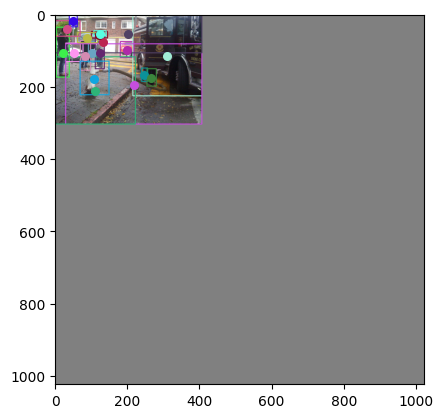

[[ 261.  302.  338.  367.]
 [ 370.  305.  405.  377.]
 [   0.    0.    0.    0.]
 [ 197.  335.  224.  364.]
 [   0.    0.    0.    0.]
 [ 147.  349.  167.  369.]
 [ 705.  667.  760.  749.]
 [   0.  213.  708.  801.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [ 678.  369. 1024.  736.]
 [   0.  647. 1024. 1024.]
 [ 507.  292. 1024.  605.]
 [   0.   47.  405.  352.]
 [   0.    0. 1024.  369.]
 [ 760.  513. 1024.  687.]
 [ 839.  625.  909.  664.]
 [   0.  297.   78.  682.]]


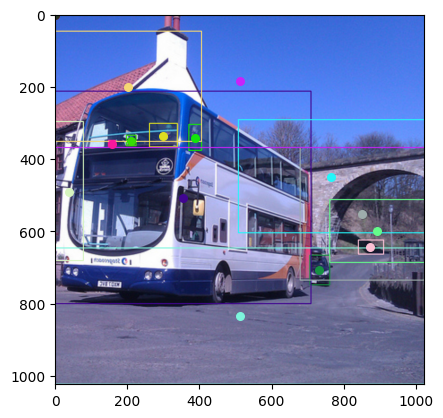

[[ 88.  28. 183. 163.]
 [ 78. 161. 191. 173.]
 [  0.   0. 317. 210.]]


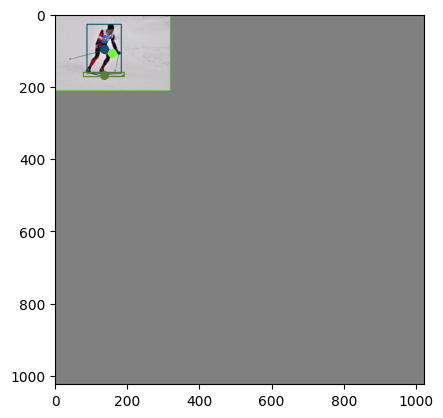

[[ 833.  621.  879.  708.]
 [   0.    0.    0.    0.]
 [ 882.  543. 1024.  708.]
 [   0.    0.    0.    0.]
 [   0.  208.  287. 1024.]
 [ 269.  610. 1024.  989.]
 [ 243.  309.  972.  726.]
 [ 764.    0. 1024.   63.]
 [   0.    0. 1024. 1024.]
 [   0.    0.    0.    0.]
 [ 954.  460. 1024.  555.]]


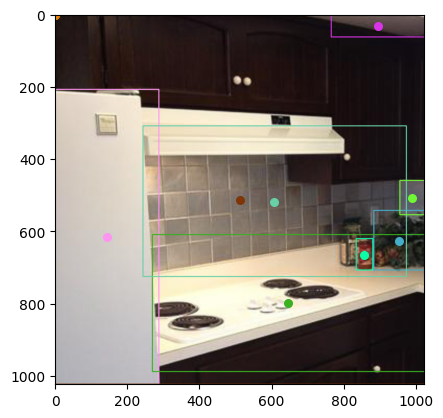

In [5]:
import cv2, random
from matplotlib import pyplot as plt
def random_color():
    rdn = random.randint(1, 1000)
    b = int(rdn * 997) % 255
    g = int(rdn * 4447) % 255
    r = int(rdn * 6563) % 255
    return b, g, r

with torch.no_grad():
    for idx, batches in enumerate(train_data_loader):
        if idx > 2:
            break
        for key, batch in batches.items():
            for idx, batch_per_image in enumerate(batch):
                obj_boxes = batch_per_image['instances'].gt_boxes.tensor
                target_img = batch_per_image["image"]
                img = target_img.permute(1, 2, 0).detach().cpu().numpy()
                obj_boxes = obj_boxes.cpu().numpy()

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                # targets_per_image = batch_per_image["instances"].to(opt.device)
                print(obj_boxes)
                for box in obj_boxes:
                    color = random_color()
                    box = box.astype(int)
                    x1, y1, x2, y2 = box
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                    x = (x1 + x2) / 2
                    y = (y1 + y2) / 2

                    plt.scatter(x, y, 30, color=[i/255 for i in color])
                    # plt.text(
                    #     x + 5,
                    #     y + 5,
                    #     label,
                    #     fontsize=10,
                    #     bbox=dict(facecolor=[i/255 for i in color], alpha=0.5),
                    #     )
                
                plt.imshow(img)
                plt.show()